In [1]:
import os

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import pyLDAvis

# Import de tous les fichiers de données

In [2]:
files = []
for r, d, f in os.walk(r".\data"):
    for file in f:
        if file.endswith(".json"):
            files.append(os.path.join(r, file))
            
tweets = pd.concat([pd.read_json(file, orient='records', encoding="UTF-8") for file in files], ignore_index=True)

In [3]:
print("{} ont été récupérés".format(tweets.shape[0]))
tweets = tweets.set_index('id')
print("{} tweets sont uniques".format(len(tweets.index.drop_duplicates())))
tweets = tweets.loc[~tweets.index.duplicated(keep='first'),:]
print(len(tweets))

17110 ont été récupérés
16901 tweets sont uniques
16901


In [38]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16901 entries, 1329190331749949442 to 1326121800800083969
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   created_at                 16901 non-null  datetime64[ns, UTC]
 1   id_str                     16901 non-null  int64              
 2   full_text                  16901 non-null  object             
 3   truncated                  16901 non-null  bool               
 4   display_text_range         16901 non-null  object             
 5   entities                   16901 non-null  object             
 6   metadata                   16901 non-null  object             
 7   source                     16901 non-null  object             
 8   in_reply_to_status_id      4800 non-null   float64            
 9   in_reply_to_status_id_str  4800 non-null   float64            
 10  in_reply_to_user_id        5089 non-nu

In [5]:
tweets.possibly_sensitive.unique()
cols = ["full_text", 'possibly_sensitive']
tweets2 = tweets[cols]
sensitive = tweets2['possibly_sensitive'] == 0
print(tweets2[sensitive][:5].full_text)

id
1329190331749949442    So many men go without routine wellness checks...
1328556798673113089    @azdhs would prefer residents of AL and LTC sh...
1327771734271922177    Bro... \nThe holiday season already sees a mas...
1327764110369558530    Playing cod for Q3 clips makes me wanna die of...
1329212632558137344    Jesus told her, “I am the resurrection and the...
Name: full_text, dtype: object


# Pré traitement des données

In [6]:
# Clean and extract count vectorizer
import spacy
nlp = spacy.load("en_core_web_sm")
lemmatizer = nlp.get_pipe("lemmatizer")

## Essais d'optimisation du temps sur 100 exemples

In [7]:
tweets3 = tweets.sample(100)

In [8]:
%%timeit
processed_tweets = [nlp(tweet) for tweet in tweets3.full_text]

1.66 s ± 67.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
%%timeit
docs = (nlp(tweet) for tweet in tweets3.full_text)

14.1 µs ± 1.61 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Le générateur est bien plus rapide donc à garder lors du traitement de l'ensemble des tweets

In [10]:
%%timeit
corpus = []
docs = (nlp(tweet) for tweet in tweets3.full_text)
for tweet in (lemmatizer(doc) for doc in docs):
    corpus.append(" ".join([w.lemma_ for w in tweet]))


1.54 s ± 43.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
%%timeit
corpus = []
docs = (nlp(tweet) for tweet in tweets3.full_text)
for tweet in lemmatizer.pipe(docs, batch_size=50):
    corpus.append(" ".join([w.lemma_ for w in tweet]))

1.56 s ± 143 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


 Le pipe de spacy est un peu moins rapide qu'un génerateur python... Néanmoins je l'utiliserais parce qu'il existe.

## Nettoyage des données
 - Lemmatisation
 - Suppression des nombres
 - Suppression des stopwords

In [12]:
import re
tweets3 = tweets.sample(1000)
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS

docs = (nlp(tweet) for tweet in tweets3.full_text)
corpus = []
for tweet in lemmatizer.pipe(docs, batch_size=50):
    corpus.append(" ".join([re.sub(r"\d+", "", w.lemma_) for w in tweet if w.lemma_ not in spacy_stopwords]))

In [13]:
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
print(list(spacy_stopwords)[:10])

['all', 'back', 'after', 'and', 'around', 'alone', '‘ll', 'does', 'throughout', 'because']


## LDA

In [14]:
import pyLDAvis
import pyLDAvis.sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

vectorizer = CountVectorizer()
doc_term_matrix = vectorizer.fit_transform(corpus)
lda_model = LatentDirichletAllocation(n_components=2, random_state=888)
lda_model.fit(doc_term_matrix)

LatentDirichletAllocation(n_components=2, random_state=888)

In [15]:
data = pyLDAvis.sklearn.prepare(lda_model, doc_term_matrix, vectorizer)
# Visualization can be displayed in the notebook
pyLDAvis.display(data)

# Test de clustering avec Kmeans et tfIdf

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [72]:
tfidf = TfidfVectorizer(
    min_df = 5,
    max_df = 0.95,
    max_features = 8000,
    stop_words = 'english',
    ngram_range=(1,2)
)
tfidf.fit(corpus)
text = tfidf.transform(corpus)

In [73]:
text.shape

(1000, 334)

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters
Fit 22 clusters
Fit 24 clusters
Fit 26 clusters
Fit 28 clusters
Fit 30 clusters
Fit 32 clusters
Fit 34 clusters
Fit 36 clusters
Fit 38 clusters
Fit 40 clusters


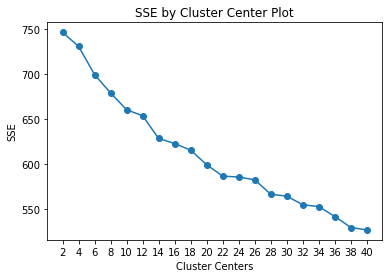

In [74]:
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(text, 40)

inertia = Sum of squared distances of samples to their closest cluster center.

In [105]:
clusters = MiniBatchKMeans(n_clusters=8, init_size=1024, batch_size=2048, random_state=20).fit_predict(text)

### Visualisation du graphique avec l'ACP

In [106]:
data = text
labels = clusters

max_label = max(labels)
#max_items = np.random.choice(range(data.shape[0]), size=100, replace=False)

pca = PCA(n_components=100).fit_transform(data.todense())
tsne = TSNE().fit_transform(PCA(n_components=100).fit_transform(data.todense()))

# idx = np.random.choice(range(pca.shape[0]), size=100, replace=False)
# label_subset = labels[max_items]
# label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]

In [95]:
pca.shape

(1000, 100)

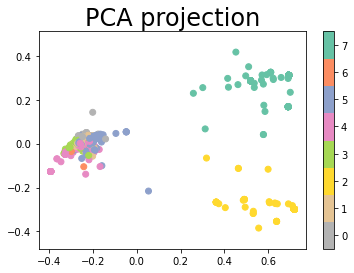

In [120]:
# f, ax = plt.subplots()

# pos = ax.scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
# f.gca().set_aspect('equal', 'datalim')

# # add the colorbar using the figure's method,
# # telling which mappable we're talking about and
# # which axes object it should be near
# f.colorbar(pos, ax=ax).set_ticks(np.arange(14))
# plt.title('UMAP projection of the Digits dataset', fontsize=24);
# ax.set_title('PCA Cluster Plot')

pos = plt.scatter(pca[:,0], pca[:,1], c=clusters, cmap="Set2_r")
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(9)-0.5).set_ticks(np.arange(8))
plt.title('PCA projection', fontsize=24);

## Top words et exemples

In [121]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
get_top_keywords(text, clusters, tfidf.get_feature_names(), 10)


Cluster 0
hurt,come,got,start,year,season,player,game,https,injure

Cluster 1
like,want,today,live die,tell,life,die,https,live,kill

Cluster 2
demonstrate listen,demonstrate,tweet try,try demonstrate,lockdown,figure lockdown,friend,lockdown friend,friend copy,copy

Cluster 3
million people,like,trump,let,covid,https,day,die,people die,people

Cluster 4
think,hill,covid,hard,die hard,like,want,die https,https,die

Cluster 5
money,let,time,people,amp,https,die,love,know,suicide

Cluster 6
good,open,phone,let die,die,let,na die,gon,gon na,na

Cluster 7
post,post tweet,figure,usa,suicide figure,usa hotline,hotline,follower,follower copy,copy


In [123]:
tweets3["clusters"]=clusters
pd.options.display.max_colwidth = 500
cluster1 = tweets3["clusters"]==2
tweets3[cluster1].full_text

id
1326962115450527744                                          Suicide figures are up 200% since lockdown. Could 2 friends please copy and re-post this tweet? We’re trying to demonstrate that someone is always listening. Call 1-800-273-8255 (USA hotline) Just two. Any two. Copy, not retweet.
1327268750870147072                                          Suicide figures are up 200% since lockdown. Could 2 friends please copy and re-post this tweet? We’re trying to demonstrate that someone is always listening. Call 1-800-273-8255 (USA hotline) Just two. Any two. Copy, not retweet.
1327066068167389185                  Suicide figures are up 200% since lockdown. Could 2 friends please copy and re-post this tweet? We’re trying to demonstrate that someone is always listening. Call 1-800-273-8255 (USA hotline) Just two. Any two. Copy, not retweet. https://t.co/pWGMXFK1qI
1326978608028499968                                          Suicide figures are up 200% since lockdown. Could 2 friends ple

Les clusters 7 et 2 sont des chaines d'appels aux hotlines concernant les suicides  
## Suppression des tweets de hotline

In [129]:
delete7 = tweets3["clusters"]==7
print("Taille de l'échantillon avant suppression:",len(tweets3))
tweets3 = tweets3[~delete7]
delete2 = tweets3["clusters"]==2
tweets3 = tweets3[~delete2]
print("Tweets restants", len(tweets3))

Taille de l'échantillon avant suppression: 719
Tweets restants 719


# Relancement de la pipeline

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters
Fit 22 clusters
Fit 24 clusters
Fit 26 clusters
Fit 28 clusters
Fit 30 clusters
Fit 32 clusters
Fit 34 clusters
Fit 36 clusters
Fit 38 clusters
Fit 40 clusters


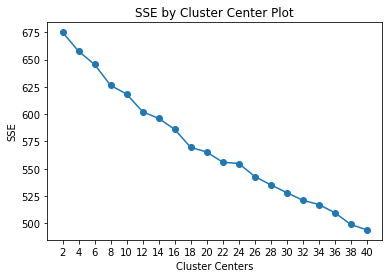

In [130]:
def clean_text(tweets):
    docs = (nlp(tweet) for tweet in tweets.full_text)
    corpus = []
    for tweet in lemmatizer.pipe(docs, batch_size=50):
        corpus.append(" ".join([re.sub(r"\d+", "", w.lemma_) for w in tweet if w.lemma_ not in spacy_stopwords]))
    return corpus

corpus = clean_text(tweets3)

tfidf = TfidfVectorizer(
    min_df = 5,
    max_df = 0.95,
    max_features = 8000,
    stop_words = 'english',
    ngram_range=(1,2)
)

tfidf.fit(corpus)
text = tfidf.transform(corpus)
find_optimal_clusters(text, 40)

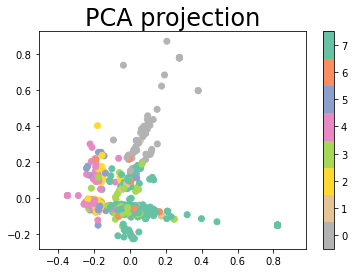

In [140]:
clusters = MiniBatchKMeans(n_clusters=8, init_size=1024, batch_size=2048, random_state=20).fit_predict(text)
data = text
labels = clusters

max_label = max(labels)
#max_items = np.random.choice(range(data.shape[0]), size=100, replace=False)

pca = PCA(n_components=100).fit_transform(data.todense())
tsne = TSNE().fit_transform(PCA(n_components=100).fit_transform(data.todense()))

pos = plt.scatter(pca[:,0], pca[:,1], c=clusters, cmap="Set2_r")
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(9)-0.5).set_ticks(np.arange(8))
plt.title('PCA projection', fontsize=24);


In [132]:
get_top_keywords(text, clusters, tfidf.get_feature_names(), 10)


Cluster 0
thousand,know,way,fucking,live die,believe,live,die,die https,https

Cluster 1
help,https,covid,live,suicide,day,wo,know,die,need

Cluster 2
hurt,come,got,start,year,season,player,game,https,injure

Cluster 3
death,million,like,trump,let,know,covid,die,people die,people

Cluster 4
prevention,suicide https,commit,life,die,amp,https,want die,want,suicide

Cluster 5
feel like,use,look,damn,wanna,want,https,like,feel,kill

Cluster 6
suicide,know,want,damn,life,https,people,love die,die,love

Cluster 7
amp,gon,hard,die hard,time,covid,think,https,let,die


In [141]:
tweets3["clusters"]=clusters
pd.options.display.max_colwidth = 500
cluster1 = tweets3["clusters"]==1
tweets3[cluster1].full_text

id
1326785906314010626                                     The LAST thing I needed all those years ago when I was mega-depressed was to be told '&lt;self-harm&gt; is on the rise'. The LAST thing I needed was to have the concept of suicide slid in front of me out of context, causing suicidal ideation to start spinning up again.
1326932063958818820                                                                                                                                                                                                                                                               How much Windex does one need to breathe in to die?
1327071195334914048                                                                                                                             This is crazy. We can do better Idaho @GovernorLittle #MaskUpIdaho needs to be mandated, "responsibility" is NOT working. How many more will get sick or die? https://t.co/HxwrbqIO0D
1328456599753650176

In [138]:
def plot_tsne_pca(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=1000, replace=False)
    
    pca = PCA(n_components=20).fit_transform(data[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=100).fit_transform(data[max_items,:].todense()))
    
    idx = np.random.choice(range(pca.shape[0]), size=1000, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset, cmap="Spectral")
    
    ax[0].set_title('PCA Cluster Plot')
    plot = ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')
    legend1 = plt.legend(*plot.legend_elements(),
                    loc="lower left", title="Classes")
    ax[1].add_artist(legend1)


    
plot_tsne_pca(text, clusters)

ValueError: Cannot take a larger sample than population when 'replace=False'

In [108]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
get_top_keywords(text, clusters, tfidf.get_feature_names(), 10)


Cluster 0
hurt,come,got,start,year,season,player,game,https,injure

Cluster 1
like,want,today,live die,tell,life,die,https,live,kill

Cluster 2
demonstrate listen,demonstrate,tweet try,try demonstrate,lockdown,figure lockdown,friend,lockdown friend,friend copy,copy

Cluster 3
million people,like,trump,let,covid,https,day,die,people die,people

Cluster 4
think,hill,covid,hard,die hard,like,want,die https,https,die

Cluster 5
money,let,time,people,amp,https,die,love,know,suicide

Cluster 6
good,open,phone,let die,die,let,na die,gon,gon na,na

Cluster 7
post,post tweet,figure,usa,suicide figure,usa hotline,hotline,follower,follower copy,copy


In [112]:
tweets3["clusters"]=clusters

id
1326966983032795137                                                                    Suicide figures are up. Could 2 followers please copy and re-post this tweet? We’re trying to demonstrate that someone is always listening. \n\nCall 1-800-273-8255 (USA hotline)\n\nJust two. Any two. Copy, not retweet.
1327009481998413825                                                                                             Suicide figures are up. Could 2 followers please copy and re-post this tweet? We’re trying to demonstrate that someone is always listening. \nReach out. \nCall 1-800-273-8255 (USA hotline) ❣️💔😢
1326900092863967234                                                                                                              Suicide figures are up 200% since lockdown. Could 2 followers please copy and re-post this tweet? \n\nCall 1-800-273-8255 (USA hotline)\n\nJust two. Any two. Copy, not retweet.
1326897348988071936                                                            

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters
Fit 22 clusters
Fit 24 clusters
Fit 26 clusters
Fit 28 clusters
Fit 30 clusters
Fit 32 clusters
Fit 34 clusters
Fit 36 clusters
Fit 38 clusters
Fit 40 clusters


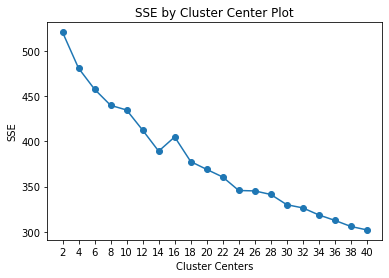

In [28]:
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(pca, 40)

In [29]:
clusters = MiniBatchKMeans(n_clusters=16, init_size=1024, batch_size=2048, random_state=20).fit_predict(tsne)